In [1]:
import numpy as np
import os
import sys
from typing import Union, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch

In [2]:
import sys
sys.path.append('..')
import helpers

In [3]:
import epde
from epde.interface.solver_integration import BoundaryConditions, BOPElement

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)

In [4]:
def Lotka_Volterra_by_RK(initial : tuple, timestep : float, steps : int, alpha : float, 
                         beta : float, delta : float, gamma : float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        # print(res[step, :])
        k1 = alpha * res[step, 0] - beta * res[step, 0] * res[step, 1]; x1 = res[step, 0] + timestep/2. * k1
        l1 = delta * res[step, 0] * res[step, 1] - gamma * res[step, 1]; y1 = res[step, 1] + timestep/2. * l1

        k2 = alpha * x1 - beta * x1 * y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = delta * x1 * y1 - gamma * y1; y2 = res[step, 1] + timestep/2. * l2

        k3 = alpha * x2 - beta * x2 * y2
        l3 = delta * x2 * y2 - gamma * y1
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = alpha * x3 - beta * x3 * y3
        l4 = delta * x3 * y3 - gamma * y3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

steps_num = 500; step = 1.5/steps_num
t = np.arange(start = 0, stop = step * steps_num, step = step)
solution = Lotka_Volterra_by_RK(initial=(4., 2.), timestep=step, steps=steps_num, 
                                alpha=20., beta=20., delta=20., gamma=20.)

In [37]:
def epde_discovery(t, x, y, diff_mode = 'FD'):
    dimensionality = x.ndim - 1
    
    '''
    Подбираем Парето-множество систем дифф. уравнений.
    '''
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, 
                                      boundary = 25, coordinate_tensors = [t,], 
                                      verbose_params = {'show_iter_idx' : False})
    
    if diff_mode == 'ANN':
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 50000})
    elif diff_mode == 'poly':
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3})
    elif diff_mode == 'FD':
        epde_search_obj.set_preprocessor(default_preprocessor_type='FD')
    else:
        raise NotImplementedError('Incorrect differentiation mode selected.')        
    
    popsize = 16
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=15)

    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.5, 0.5]}
    
    epde_search_obj.fit(data=[x, y], variable_names=['u', 'v'], max_deriv_order=(1,),
                        equation_terms_max_number=6, data_fun_pow = 1,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(5*1e-3, 1e-1))       
    return epde_search_obj

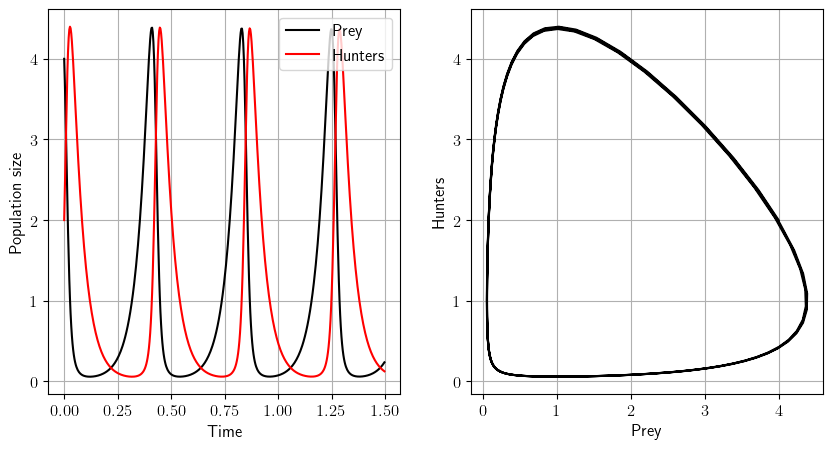

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(t, solution[:, 0], color= 'k', label = 'Prey')
ax1.plot(t, solution[:, 1], color= 'r', label = 'Hunters')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population size')
ax1.legend(loc = 'upper right')
ax1.grid()

ax2.set_xlabel('Prey')
ax2.set_ylabel('Hunters')
ax2.plot(solution[:, 0], solution[:, 1], color= 'k')
ax2.grid()
plt.show()

In [39]:
t_max = 250
t_train = t[:t_max]; t_test = t

x = solution[:t_max, 0]; x_test = solution[:, 0]
y = solution[:t_max, 1]; y_test = solution[:, 1]

epde_search_obj = epde_discovery(t_train, x, y, 'poly')
epde_search_obj.equations(only_print = True, num = 1)  

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fbb5b4e17f0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7fbb5b4e17f0>
Deriv orders after definition [[0]]
250
initial_shape (250,) derivs_tensor.shape (250, 1)
self.tokens is ['du/dx0']
Here, derivs order is {'du/dx0': [0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
Deriv orders after definition [[0]]
250
initial_shape (250,) derivs_tensor.shape (250, 1)
self.tokens is ['dv/dx0']
Here, derivs order is {'dv/dx0': [0]}
self.tokens is ['v']
Here, derivs order is {'v': [None]}
The cardinality of defined token pool is [1 1 1 1]
Among them, the pool contains [1 1 1 1]
self.vars_demand_equation {'v', 'u'}
Creating new equation, sparsity value [0.01823202 0.0071639 ]
New solution accepted, confirmed 1/16 solutions.
Creating new equation, sparsity value [0.04546884 0.09630811]
New solution accepted, confirmed 2/16 solutions.
Creating new equation, sparsity value [0.03648568 0.

In [40]:
levels = epde_search_obj.optimizer.pareto_levels

import epde.loader as Loader

path_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'examples', 'data')

print(path_dir)
loader = Loader.EPDELoader()
loader.save(obj=levels, filename=os.path.join(path_dir, 'LV_levels.pickle')) # Pickle-saving an equation
loader.save(obj = epde_search_obj.pool, filename=os.path.join(path_dir, 'LV_pool.pickle'))

/home/maslyaev/epde/EPDE_main/examples/data


In [21]:
disc_eq = epde_search_obj.get_equations_by_complexity([2.5, 2.5])[0]

In [22]:
disc_eq.text_form

" / 0.0 * u{power: 2.0} + 0.0 * v{power: 1.0} * dv/dx0{power: 1.0} + 0.0 * dv/dx0{power: 1.0} * u{power: 2.0} + -19.912841005191233 * u{power: 1.0} * v{power: 1.0} + 19.93080617561809 * u{power: 1.0} + 0.00014852091762681453 = du/dx0{power: 1.0}\n \\ 0.0 * u{power: 1.0} * du/dx0{power: 1.0} + -19.965163383852133 * v{power: 1.0} + 0.0 * v{power: 2.0} + 19.922283013883117 * v{power: 1.0} * u{power: 1.0} + 0.0 * v{power: 1.0} * du/dx0{power: 1.0} + 0.017791429721632876 = dv/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.5, 0.5]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.22133851966854234}, ('sparsity', 'v'): {'optimizable': True, 'value': 0.15024818706986184}}"

In [23]:
def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

bop_u = get_ode_bop('u', 0, [None,], t_test[0], x_test[0])

bop_v = get_ode_bop('v', 1, [None,], t_test[0], y_test[0])

In [24]:
t_test.shape

(500,)

In [26]:
t_oversampled = np.linspace(t_test[0], t_test[-1])
pred_u_v = epde_search_obj.predict(system=disc_eq, grid = [t_test.reshape((1, -1)),], 
                                   boundary_conditions=[bop_u(), bop_v()],
                                   mode='mat', use_fourier = True, fourier_params = {'L' : [15,], 'M' : [6,]}, 
                                   optimizer_params={'optimizer': 'LBFGS', 'params': {'lr': 0.1}, 'gamma': 0.9, 
                                                     'decay_every': 400},
                                   compiling_params = {'tol' : 0.02}, use_adaptive_lambdas=False)

Using explicitly sent system of equations.


TypeError: __init__() got an unexpected keyword argument 'use_fourier'

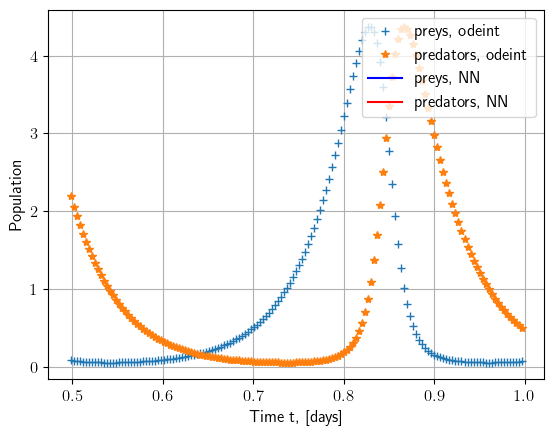

In [37]:
plt.plot(t_test, x_test, '+', label = 'preys, odeint')
plt.plot(t_test, y_test, '*', label = "predators, odeint")
plt.plot(t_oversampled, pred_u_v[0, :], color = 'b', label='preys, NN')
plt.plot(t_oversampled, pred_u_v[1, :], color = 'r', label='predators, NN')
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.grid()
plt.legend(loc='upper right')
plt.show()

In [ ]:
pred_u_v.shape